<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/crop_field_delineation_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop Field Delineation using U-Net in Pytorch
**Creator**: Isabelle Tingzon

Welcome to our tutorial on crop field delineation using Pytorch. Here, you will learn how to train a computer vision model to segment crop fields using publicly available Sentinel-2 satellite imagery.

You can make a copy of this tutorial by clicking File→Save a copy in Drive.

# Table of Contents

*   [Overview](#overview)
*   [Climate Impact](#climate-impact)
*   [Target Audience](#target-audience)
*   [Background & Prerequisites](#background-and-prereqs)
*   [References](#references)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)


<a name="overview"></a>
# Overview

In this tutorial, you will learn how to:
- Train a computer vision model for semantic segmentation
- Create a Pytorch implementation of the U-net architecture
- Save and load trained models


<a name="climate-impact"></a>
# Climate Impact
The accurate delineation of crop fields is essential for better decision-making by farmers and workers in the agricultural sector. By providing improved cadastral data, crop field delineation models can help facilitate land registration and acquisition for farmers. Crop field boundary data can also help inform climate change policies, for example, by providing better estimates of cropland area for GHG estimation and damage assessment after a natural disaster.

<center><p><p> <img src="https://images.squarespace-cdn.com/content/v1/5c45bc92ec4eb7bfa5be0b26/1551946410968-1SCTT70MTSTC3HSKN8WG/pexels-photo-1483880.jpg?format=1500w" alt="alt" width="50%"/>

<a name="target-audience"></a>
# Target Audience
This tutorial is aimed at data scientists with prior background in deep learning looking for concrete examples on the application of deep learning models to tackle a problem in climate change.

<a name="background-and-prereqs"></a>
# Background and Prerequisites
This tutorial is intended for data scientists with prior knowledge of machine learning concepts, including neural networks.

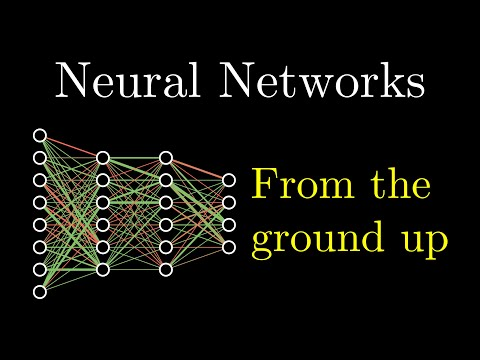

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk')

# References

*  C. Yeh, C. Meng, S. Wang, A. Driscoll, E. Rozi, P. Liu, J. Lee, M. Burke, D. Lobell, and S. Ermon, “SustainBench: Benchmarks for Monitoring the Sustainable Development Goals with Machine Learning,” in Thirty-fifth Conference on Neural Information Processing Systems, Datasets and Benchmarks Track (Round 2), Dec. 2021. [Online]. Available: https://openreview.net/forum?id=5HR3vCylqD. Github: https://sustainlab-group.github.io/sustainbench/
*  Buda, M., Saha, A., & Mazurowski, M. A. (2019). Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm. Computers in biology and medicine, 109, 218-225. https://github.com/mateuszbuda/brain-segmentation-pytorch

<a name="software-requirements"></a>
# Software Requirements

This notebook requires Python >= 3.7. The following libraries are required:
*   tqdm
*   pandas
*   numpy
*   matplotlib
*   pytorch

## Enabling GPU in Google Colab
Before we start, you will need access to a GPU.  Fortunately, Google Colab provides free access to computing resources including GPUs. The GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s. Unfortunately, there is no way to choose what type of GPU you can connect to in Colab. [See here for information](https://research.google.com/colaboratory/faq.html#gpu-availability).

To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

In [ ]:
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Google Colab GPU
Check that the GPU  enabled in your colab notebook by running the cell below.

In [ ]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


## Mount Drive

Mounting the drive will allow the Google Colab notebook to load and access files from your Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="data-description"></a>
# Data Description

In this section, we will download a copy of the crop field delineation dataset. the dataset is taken from [SustainBench](https://sustainlab-group.github.io/sustainbench/), a suite of sustainability benchmarks targeting the UN Sustainable Development Goals (SDGs). The crop field delineation dataset can be found [here](https://drive.google.com/drive/folders/1GDL1pvlDCcsyEwafe7N41WtS7doFlju3).

In [ ]:
!pip -q install -U --no-cache-dir gdown --pre
gdrive_id = '1gq9v_4acxkx-HNHKesMWbHBT3nwvtCuN'
!gdown --id $gdrive_id
!unzip -q /content/crop_delineation.zip -d /content/

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1gq9v_4acxkx-HNHKesMWbHBT3nwvtCuN
From (redirected): https://drive.google.com/uc?id=1gq9v_4acxkx-HNHKesMWbHBT3nwvtCuN&confirm=t&uuid=e689a0e8-2dc5-414e-8243-f55b419e4a38
To: /content/crop_delineation.zip
100% 31.8M/31.8M [00:00<00:00, 60.4MB/s]


## File Locations

In [ ]:
cwd = './drive/My Drive/Colab Notebooks/Crop Field Delineation/'
data_dir = 'crop_delineation/'
images_dir = data_dir + 'imgs/'
masks_dir = data_dir + 'masks/'
clean_data_file = data_dir + 'clean_data.csv'

## Load Dataset
The `clean_data.csv` file indicates the train/test split among indices. This will be important for generating our Pytorch DataLoaders later on.

In [ ]:
clean_data = pd.read_csv(clean_data_file)
clean_data.head(3)

,ids,indices,split,max_lat,max_lon,min_lat,min_lon
0,0,4813734,train,47.956223,2.055750,47.942745,2.035627
1,1,2521449,train,44.981155,5.026029,44.966919,5.005907
2,2,11061277,train,48.297222,-0.062747,48.283833,-0.082870


## Visualize Imagery and Mask
Let's start by visualizing the first index in the `clean_data.csv` file. Specifically, each index has a corresponding image and pixel mask, which we plot using matplotlib below.

(224, 224, 3)


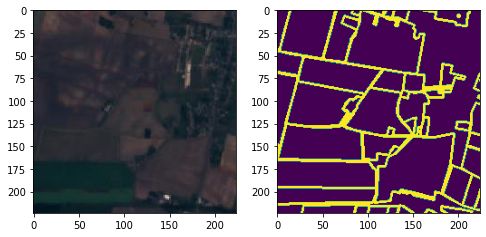

In [ ]:
index = clean_data.iloc[0]['indices']
image_path = images_dir + str(index) + '.jpeg'
mask_path = masks_dir + str(index) + '.png'
image = plt.imread(image_path)
mask = plt.imread(mask_path)
print(image.shape)

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(image)
ax[1].imshow(mask);

## Create Pytorch Dataloader
In Pytorch, the `Dataset` class allows you to define a custom class to load the input and target for a dataset. In the next cell, we define a custom Pytorch dataset CFDDataset. The `__getitem__()` module returns an (image, mask) pair, converted to Pytorch tensors, for a specified index.

In [ ]:
class CFDDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        index_ = self.dataset.iloc[index]['indices']

        # Get image and mask file paths for specified index
        image_path = images_dir + str(index_) + '.jpeg'
        mask_path = masks_dir + str(index_) + '.png'

        # Read image
        image = plt.imread(image_path)
        image = image.transpose((2, 1, 0))

        # Read image
        mask = plt.imread(mask_path)
        mask = mask.transpose((1, 0))[None, :]

        # Convert to Pytorch tensor
        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        return image_tensor, mask_tensor

    def __len__(self):
        return len(self.dataset)

In the following, we create a function for generating pytorch dataloaders. we use `torch`'s `DataLoader` class to create a dataloader.  The dataloader manages fetching samples from the datasets (it can even fetch them in parallel using `num_workers`) and assembles batches of the datasets.

In [ ]:
def get_dataloaders(data, batch_size):
    datasets = {
        'train' : CFDDataset(data[data.split == 'train']),
        'test' : CFDDataset(data[data.split == 'test'])
    }

    dataloaders = {
        'train': DataLoader(
          datasets['train'],
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers
        ),
        'test': DataLoader(
          datasets['test'],
          batch_size=batch_size,
          drop_last=False,
          num_workers=num_workers
        )
    }
    return dataloaders

## Visualize Crop Field Training Set
Next, let's create a function for visualizing a batch of images.

In [ ]:
def visualize_batch(batch, batch_size):
  fig, ax = plt.subplots(2, 4, figsize=(batch_size*3, batch_size*1.5))

  for i in range(batch_size):
    image = batch[0][i].cpu().numpy()
    mask = batch[1][i].cpu().numpy()

    image = image.transpose((1, 2, 0))
    mask = mask.transpose((1, 2, 0)).squeeze()

    image = (image * 255.0).astype("uint8")
    mask = (mask * 255.0).astype("uint8")

    ax[0, i].imshow(image)
    ax[1, i].imshow(mask)
    plt.axis("off")

  plt.tight_layout()
  plt.show()

Let's visualize a batch of 4 images as follows.

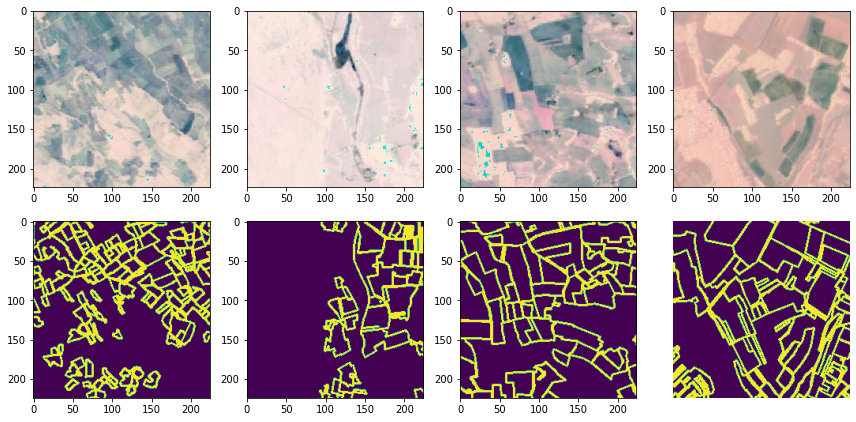

In [ ]:
batch_size = 4
num_workers = 2
dataloaders = get_dataloaders(clean_data, batch_size=batch_size)
train_batch = next(iter(dataloaders['train']))
visualize_batch(train_batch, batch_size)

<a name="methodology"></a>
# Model Development

In this section, we'll briefly dicuss how to implement one type of semantic segmentation model architecture called U-net. To learn more about the semantic segmentation, we recommend you watch the Stanford CS231N lecture here:

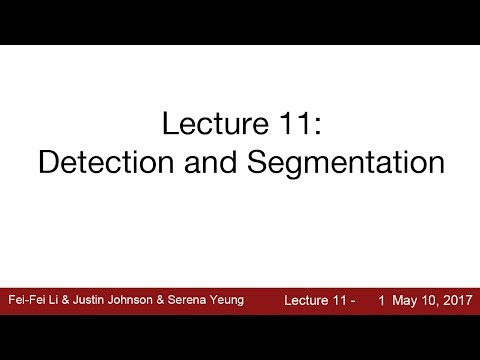

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('nDPWywWRIRo')

## U-net Architecture

Let's look a bit more closely at the U-net architecture. The Unet, named after its U-shaped structure, consists of an encoder-decoder (also called contractive-expansive) scheme, where
*   the **encoder** decreases the spatial dimensions at every layer while increasing the number of channels
*   the **decoder** then gradually increases the spatial dimensions back to the original dimensions using transpose convolutions

U-net also takes advantage of long skip connections, which involves taking high-level information from earlier encoder layers and concatenating it with low-level features from the decoder layers, allowing the recovery of fine-grained details.


<center><p><p> <img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="alt" width="50%"/>

[Source](https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/mateuszbuda_brain-segmentation-pytorch_unet.ipynb): U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=32):
        super().__init__()

        self.encoder1 = self.block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.block(features, features*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.block(features*2, features*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.block(features*4, features*8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self.block(features*8, features*16)

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = self.block(features*16, features*8)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = self.block(features*8, features*4)
        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = self.block(features*4, features*2)
        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self.block(features*2, features)

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), dim=1))
      dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), dim=1))
      dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), dim=1))
      dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), dim=1))

      return torch.sigmoid(self.conv(dec1))

    def block(self, in_channels, out_channels):
      return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
      )

## Instantiate Model
We can now instantiate a U-net model. To make sure it works, we pass a sample batch through the network and check that there are no errors.

In [ ]:
model = Unet()
print(model)
input, target = next(iter(dataloaders['train']))
pred = model(input)
pred.shape

Unet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Sequential(
    (0): Conv2d(6

torch.Size([4, 1, 224, 224])

## Define Dice Loss
One popular loss function for semantic segmentation is the Dice Loss. The dice coefficient measures the overlap between two samples, wherein values closer to 1 indicate perfect overlap.

<center><p><p> <img src="https://pbs.twimg.com/media/EWci84bWsAIBWvV?format=png&name=small" alt="alt" width="30%"/>

Image Source: [https://twitter.com/caropetitjean/status/1254016170820284417?lang=eu](https://twitter.com/caropetitjean/status/1254016170820284417?lang=eu)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, lambda_=1.):
        super(DiceLoss, self).__init__()
        self.lambda_ = lambda_

    def forward(self, y_pred, y_true):
        y_pred = y_pred[:, 0].view(-1)
        y_true = y_true[:, 0].view(-1)
        intersection = (y_pred * y_true).sum()
        dice_loss = (2. * intersection  + self.lambda_) / (
            y_pred.sum() + y_true.sum() + self.lambda_
        )
        return 1. - dice_loss

## Training Function

We can now proceed to model training and evaluation.

This section has three major parts:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

Let's start by creating our train function.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train(True)

  for input, target in tqdm(dataloader, total=len(dataloader)):
    input = input.to(device)
    target = target.to(device)

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      output = model(input)
      loss = criterion(output, target)

      loss.backward()
      optimizer.step()

  return loss

## Evaluation Function
Next, let's define the model evaluation function.

In [ ]:
def evaluate(model, dataloader, criterion):
  model.eval()
  for input, target in tqdm(dataloader, total=len(dataloader)):
    input = input.to(device)
    target = target.to(device)

    with torch.set_grad_enabled(False):
      output = model(input)
      loss = criterion(output, target)

  return loss

## Hyperparameters

In the next cell, we'll define our hyperparameters (number of epochs, learning rate), criterion, and optimizer.

In [ ]:
n_epochs = 15
learning_rate = 0.0001
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Train and Evaluate Model
Putting it all together, we can now commence training and evaluation in the following cell.

In [ ]:
model.cuda()
for epoch in range(1, n_epochs + 1):
  print("\nEpoch {}/{}".format(epoch, n_epochs))
  print("-" * 10)

  train_loss = train(
      model,
      dataloaders["train"],
      criterion,
      optimizer
  )
  val_loss = evaluate(
      model,
      dataloaders['test'],
      criterion
  )
  print('Train loss: {}, Val loss: {}'.format(
      train_loss.cpu().detach().numpy(),
      val_loss.cpu().detach().numpy())
  )


Epoch 1/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.5692571997642517, Val loss: 0.4341217875480652

Epoch 2/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.4552329182624817, Val loss: 0.4113689661026001

Epoch 3/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.5376492738723755, Val loss: 0.38960129022598267

Epoch 4/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.42620426416397095, Val loss: 0.3741251230239868

Epoch 5/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.46561288833618164, Val loss: 0.3838313817977905

Epoch 6/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.44088196754455566, Val loss: 0.3673921823501587

Epoch 7/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.35896140336990356, Val loss: 0.36842453479766846

Epoch 8/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.39305198192596436, Val loss: 0.36095261573791504

Epoch 9/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.34654945135116577, Val loss: 0.37135785818099976

Epoch 10/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.3487856388092041, Val loss: 0.34680241346359253

Epoch 11/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.3716917037963867, Val loss: 0.37036287784576416

Epoch 12/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.3695029020309448, Val loss: 0.35217100381851196

Epoch 13/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.3785932660102844, Val loss: 0.3667922019958496

Epoch 14/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.30292075872421265, Val loss: 0.3502901792526245

Epoch 15/15
----------


  0%|          | 0/393 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Train loss: 0.33619368076324463, Val loss: 0.3489479422569275


## Save Model

In [ ]:
model_dir = cwd+"models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = model_dir + 'best_model_20220302.pth'
torch.save(model.state_dict(), model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to ./drive/My Drive/Colab Notebooks/Crop Field Delineation/models/best_model_20220302.pth


## Load Model

In [ ]:
model_dir = "./drive/My Drive/Colab Notebooks/Crop Field Delineation/models/"
model_file = model_dir + 'best_model_20220302.pth'

loaded_model = Unet()
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Model file ./drive/My Drive/Colab Notebooks/Crop Field Delineation/models/best_model_20220302.pth successfully loaded.


# Evaluate on a Single Image

(224, 224, 3)


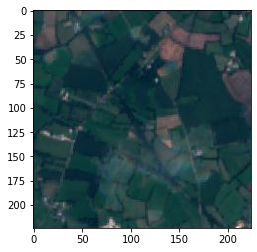

In [ ]:
i = 2
model.eval()
index = clean_data[clean_data.split == 'test' ].iloc[i]['indices']
image_path = images_dir + str(index) + '.jpeg'
image = plt.imread(image_path)
print(image.shape)
plt.imshow(image);

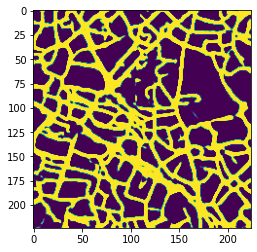

In [ ]:
image = image.transpose((2, 1, 0))[None, :]
image = torch.from_numpy(image.astype(np.float32)).to(device)
pred = model(image).cpu().detach().numpy()
pred = pred.squeeze().transpose((1, 0))
pred = (pred * 255.0).astype("uint8")
plt.imshow(pred)

Great job making it this far! Checkout [Part 2: Automating Crop Field Delineation using Python](https://colab.research.google.com/drive/1SUtvdW2ILUtf7vhLPZCTdpbf3pqisiU9?usp=sharing) to learn how to use the trained model to generate crop field vectors for an area of interest.